## Frequency Analysis

Generating a complex pattern (distribution) from a single value can be done with dense layers, conv layer and recurrent layers. Autoencoders and Variational Autoencoders can easily be trained to decode a small latent-space vector into a complex image or waveform.

This document investigates what kinds of networks are best suited to extract the required information needed to re-generate an input waveform.

Ideally, we want a network that performs a component analysis of an input sample, and outputs the frequencies of the sinewaves that it consists of.

In [1]:
from __future__ import division

import keras
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline
# local libs
import config, models, setup
import midi
from midi import generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [3]:
context = setup.init()

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 10.0 0.5
 >> Context(max_t=2.0, dt=0.05, n_timesteps=40, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  40.000000
 max_f: 10.000000, min_f: 0.500000


In [4]:
n = 10 * 1
dim4 = True
multiTrack = True
x_train, labels = setup.import_data(context, n, dim4=dim4, multiTrack=multiTrack)


Importing midi-data

Encoding midi-data
 10
> -> multi-track = True global
 [INFO] : 
 |  True
 [INFO] : 
 |  reduced mt list dims:
 |  (10, 40, 13)


In [5]:
n = 1000
min_f = 0
max_f = 4
x_train, params = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f,
    n_polyrythms=1,
    n_channels=1,
    d_phase=False,
    dim4=dim4,
    multiTrack=multiTrack)

 [INFO] : 
 |  True
 [INFO] : 
 |  reduced mt list dims:
 |  (1000, 40, 1)


In [6]:
params.shape # n, n_channels, n_polyrythms

(1000, 1, 1)

In [7]:
x_train.shape

(1000, 40, 1, 1)

In [8]:
# train test split
m = int(x_train.shape[0] * 0.9)

(array([1., 1., 1., 1., 0., 2., 0., 2., 1., 1.]),
 array([0.73687502, 1.04142369, 1.34597236, 1.65052102, 1.95506969,
        2.25961836, 2.56416702, 2.86871569, 3.17326436, 3.47781302,
        3.78236169]),
 <a list of 10 Patch objects>)

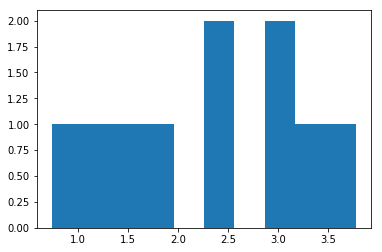

In [9]:
plt.hist(params[:10,0,0])

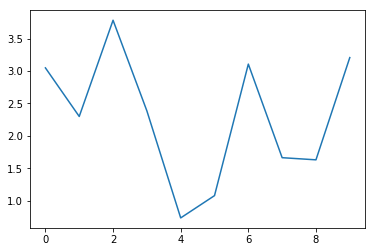

In [10]:
plt.plot(params[:10,0,0])

In [11]:
# range_ = (max_f - min_f)
range_ = max_f + 1 # extra margin = 1
y_train = params[:,0,0] / range_
y_train.shape

(1000,)

In [12]:
x_train.shape

(1000, 40, 1, 1)

In [13]:
x_test = x_train[m:]
x_train = x_train[:m]
y_test = y_train[m:]
y_train = y_train[:m]

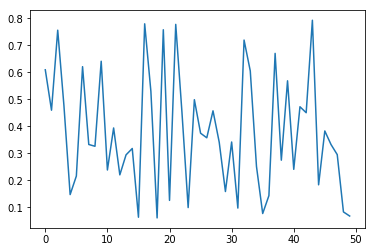

In [14]:
plt.plot(y_train[:50])

m (30, 1)


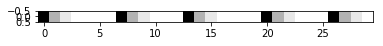

m (30, 1)


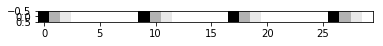

[0.60969224 0.45999421]


In [15]:
i = 0
plot.single(x_train[i,:30,0])
plot.single(x_train[i+1,:30,0])
print(y_train[i:i+2])

Make sure all frequencies fall inside the window

m (30, 1)


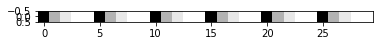

m (30, 1)


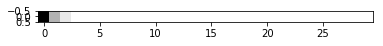

0.7999618268937279 0.0


In [16]:
i = y_train.argmax()
j = y_train.argmin()
plot.single(x_train[i,:30,0])
plot.single(x_train[j,:30,0])
print(y_train[i], y_train[j])

In [17]:
input_shape = x_train[0].shape
input_shape

(40, 1, 1)

In [18]:
timesteps, notes, channels = input_shape

encoder_input = Input(shape=(timesteps, notes, channels))
x = encoder_input

x = Reshape((timesteps, notes))(x)
# x = Reshape((timesteps, notes,1,1))(x)
# x = SimpleRNN(1)(x)
x = SimpleRNN(4, unroll=True)(x)
# x = ConvLSTM2D(3, kernel_size=(1,1))(x)
# x = Flatten()(x)
x = Dense(4, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

encoder_output = x

encoder_model = Model(encoder_input, encoder_output, name='encoder-')
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 1, 1)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 40, 1)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 4)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


In [19]:
loss = 'mse' # mse mae binary_crossentropy rmsprop adadelta
encoder_model.compile(loss=loss, optimizer='rmsprop', metrics=['accuracy','mae','binary_crossentropy'])

In [20]:
phase_mod = 0.1
whitening = False

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
#         zca_epsilon=10,
        zca_whitening=whitening,
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.,  # note-channel mod, but not shuffled
        height_shift_range=phase_mod,  # start_t, phase
        horizontal_flip=False,  # reverse
        vertical_flip=False)

datagen.fit(x_train)

In [21]:
batch_size = 100
epochs = 500

In [22]:
data_augmentation = False
# data_augmentation = True

callbacks = []
# callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]

if not data_augmentation:
    print('Not using data augmentation.')
#     history = ae.fit(x_train, epochs=epochs, validation_data=(x_test, None))
    history = encoder_model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=callbacks,
        shuffle=True)
else:
    print('Using real-time data augmentation.')    
    history = encoder_model.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=callbacks,
        workers=4)

Not using data augmentation.
Train on 900 samples, validate on 100 samples
Epoch 1/500
900/900 [==============================] - 1s 983us/step - loss: 0.0540 - acc: 0.0033 - mean_absolute_error: 0.1982 - binary_crossentropy: 0.6771 - val_loss: 0.0481 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.1907 - val_binary_crossentropy: 0.6642
Epoch 2/500
900/900 [==============================] - 0s 48us/step - loss: 0.0465 - acc: 0.0033 - mean_absolute_error: 0.1857 - binary_crossentropy: 0.6618 - val_loss: 0.0455 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.1852 - val_binary_crossentropy: 0.6588
Epoch 3/500
900/900 [==============================] - 0s 46us/step - loss: 0.0440 - acc: 0.0033 - mean_absolute_error: 0.1800 - binary_crossentropy: 0.6565 - val_loss: 0.0422 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.1782 - val_binary_crossentropy: 0.6520
Epoch 4/500
900/900 [==============================] - 0s 47us/step - loss: 0.0401 - acc: 0.0033 - mean_absolute_error: 0.1717

900/900 [==============================] - 0s 34us/step - loss: 0.0059 - acc: 0.0033 - mean_absolute_error: 0.0649 - binary_crossentropy: 0.5706 - val_loss: 0.0044 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0538 - val_binary_crossentropy: 0.5663
Epoch 32/500
900/900 [==============================] - 0s 35us/step - loss: 0.0061 - acc: 0.0033 - mean_absolute_error: 0.0651 - binary_crossentropy: 0.5708 - val_loss: 0.0046 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0538 - val_binary_crossentropy: 0.5664
Epoch 33/500
900/900 [==============================] - 0s 34us/step - loss: 0.0056 - acc: 0.0033 - mean_absolute_error: 0.0629 - binary_crossentropy: 0.5698 - val_loss: 0.0059 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0652 - val_binary_crossentropy: 0.5696
Epoch 34/500
900/900 [==============================] - 0s 32us/step - loss: 0.0056 - acc: 0.0033 - mean_absolute_error: 0.0630 - binary_crossentropy: 0.5697 - val_loss: 0.0043 - val_acc: 0.0000e+00 - val_mean_ab

Epoch 62/500
900/900 [==============================] - 0s 40us/step - loss: 0.0034 - acc: 0.0033 - mean_absolute_error: 0.0486 - binary_crossentropy: 0.5637 - val_loss: 0.0027 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0425 - val_binary_crossentropy: 0.5612
Epoch 63/500
900/900 [==============================] - 0s 37us/step - loss: 0.0033 - acc: 0.0033 - mean_absolute_error: 0.0478 - binary_crossentropy: 0.5635 - val_loss: 0.0045 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0572 - val_binary_crossentropy: 0.5653
Epoch 64/500
900/900 [==============================] - 0s 40us/step - loss: 0.0035 - acc: 0.0033 - mean_absolute_error: 0.0494 - binary_crossentropy: 0.5641 - val_loss: 0.0026 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0419 - val_binary_crossentropy: 0.5610
Epoch 65/500
900/900 [==============================] - 0s 40us/step - loss: 0.0026 - acc: 0.0033 - mean_absolute_error: 0.0428 - binary_crossentropy: 0.5619 - val_loss: 0.0024 - val_acc: 0.0000e+00 

Epoch 93/500
900/900 [==============================] - 0s 38us/step - loss: 0.0027 - acc: 0.0033 - mean_absolute_error: 0.0442 - binary_crossentropy: 0.5618 - val_loss: 0.0020 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0376 - val_binary_crossentropy: 0.5591
Epoch 94/500
900/900 [==============================] - 0s 34us/step - loss: 0.0022 - acc: 0.0033 - mean_absolute_error: 0.0394 - binary_crossentropy: 0.5607 - val_loss: 0.0026 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0435 - val_binary_crossentropy: 0.5605
Epoch 95/500
900/900 [==============================] - 0s 38us/step - loss: 0.0027 - acc: 0.0033 - mean_absolute_error: 0.0438 - binary_crossentropy: 0.5618 - val_loss: 0.0021 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0374 - val_binary_crossentropy: 0.5593
Epoch 96/500
900/900 [==============================] - 0s 38us/step - loss: 0.0024 - acc: 0.0033 - mean_absolute_error: 0.0410 - binary_crossentropy: 0.5611 - val_loss: 0.0022 - val_acc: 0.0000e+00 

Epoch 124/500
900/900 [==============================] - 0s 34us/step - loss: 0.0025 - acc: 0.0033 - mean_absolute_error: 0.0417 - binary_crossentropy: 0.5612 - val_loss: 0.0017 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0345 - val_binary_crossentropy: 0.5582
Epoch 125/500
900/900 [==============================] - 0s 38us/step - loss: 0.0019 - acc: 0.0033 - mean_absolute_error: 0.0367 - binary_crossentropy: 0.5598 - val_loss: 0.0021 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0367 - val_binary_crossentropy: 0.5589
Epoch 126/500
900/900 [==============================] - 0s 39us/step - loss: 0.0022 - acc: 0.0033 - mean_absolute_error: 0.0394 - binary_crossentropy: 0.5605 - val_loss: 0.0017 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0342 - val_binary_crossentropy: 0.5581
Epoch 127/500
900/900 [==============================] - 0s 34us/step - loss: 0.0023 - acc: 0.0033 - mean_absolute_error: 0.0391 - binary_crossentropy: 0.5605 - val_loss: 0.0018 - val_acc: 0.0000e

900/900 [==============================] - 0s 40us/step - loss: 0.0020 - acc: 0.0033 - mean_absolute_error: 0.0369 - binary_crossentropy: 0.5598 - val_loss: 0.0015 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0317 - val_binary_crossentropy: 0.5575
Epoch 155/500
900/900 [==============================] - 0s 38us/step - loss: 0.0021 - acc: 0.0033 - mean_absolute_error: 0.0355 - binary_crossentropy: 0.5598 - val_loss: 0.0029 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0440 - val_binary_crossentropy: 0.5606
Epoch 156/500
900/900 [==============================] - 0s 44us/step - loss: 0.0016 - acc: 0.0033 - mean_absolute_error: 0.0320 - binary_crossentropy: 0.5589 - val_loss: 0.0019 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0354 - val_binary_crossentropy: 0.5584
Epoch 157/500
900/900 [==============================] - 0s 33us/step - loss: 0.0019 - acc: 0.0033 - mean_absolute_error: 0.0358 - binary_crossentropy: 0.5596 - val_loss: 0.0014 - val_acc: 0.0000e+00 - val_mean

Epoch 185/500
900/900 [==============================] - 0s 46us/step - loss: 0.0020 - acc: 0.0033 - mean_absolute_error: 0.0360 - binary_crossentropy: 0.5596 - val_loss: 0.0014 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0303 - val_binary_crossentropy: 0.5572
Epoch 186/500
900/900 [==============================] - 0s 120us/step - loss: 0.0020 - acc: 0.0033 - mean_absolute_error: 0.0362 - binary_crossentropy: 0.5596 - val_loss: 0.0014 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0316 - val_binary_crossentropy: 0.5573
Epoch 187/500
900/900 [==============================] - 0s 89us/step - loss: 0.0017 - acc: 0.0033 - mean_absolute_error: 0.0331 - binary_crossentropy: 0.5589 - val_loss: 0.0028 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0432 - val_binary_crossentropy: 0.5603
Epoch 188/500
900/900 [==============================] - 0s 47us/step - loss: 0.0019 - acc: 0.0033 - mean_absolute_error: 0.0359 - binary_crossentropy: 0.5595 - val_loss: 0.0015 - val_acc: 0.0000

900/900 [==============================] - 0s 47us/step - loss: 0.0020 - acc: 0.0033 - mean_absolute_error: 0.0375 - binary_crossentropy: 0.5597 - val_loss: 0.0015 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0311 - val_binary_crossentropy: 0.5573
Epoch 216/500
900/900 [==============================] - 0s 76us/step - loss: 0.0013 - acc: 0.0033 - mean_absolute_error: 0.0277 - binary_crossentropy: 0.5579 - val_loss: 0.0037 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0494 - val_binary_crossentropy: 0.5619
Epoch 217/500
900/900 [==============================] - 0s 51us/step - loss: 0.0021 - acc: 0.0033 - mean_absolute_error: 0.0364 - binary_crossentropy: 0.5599 - val_loss: 0.0014 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0306 - val_binary_crossentropy: 0.5571
Epoch 218/500
900/900 [==============================] - 0s 53us/step - loss: 0.0019 - acc: 0.0033 - mean_absolute_error: 0.0361 - binary_crossentropy: 0.5594 - val_loss: 0.0021 - val_acc: 0.0000e+00 - val_mean

Epoch 246/500
900/900 [==============================] - 0s 42us/step - loss: 0.0018 - acc: 0.0033 - mean_absolute_error: 0.0345 - binary_crossentropy: 0.5590 - val_loss: 0.0018 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0337 - val_binary_crossentropy: 0.5578
Epoch 247/500
900/900 [==============================] - 0s 38us/step - loss: 0.0018 - acc: 0.0033 - mean_absolute_error: 0.0350 - binary_crossentropy: 0.5591 - val_loss: 0.0014 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0315 - val_binary_crossentropy: 0.5572
Epoch 248/500
900/900 [==============================] - 0s 35us/step - loss: 0.0013 - acc: 0.0033 - mean_absolute_error: 0.0288 - binary_crossentropy: 0.5580 - val_loss: 0.0014 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0300 - val_binary_crossentropy: 0.5570
Epoch 249/500
900/900 [==============================] - 0s 35us/step - loss: 0.0021 - acc: 0.0033 - mean_absolute_error: 0.0377 - binary_crossentropy: 0.5599 - val_loss: 0.0013 - val_acc: 0.0000e

900/900 [==============================] - 0s 38us/step - loss: 0.0012 - acc: 0.0033 - mean_absolute_error: 0.0274 - binary_crossentropy: 0.5577 - val_loss: 0.0014 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0304 - val_binary_crossentropy: 0.5570
Epoch 277/500
900/900 [==============================] - 0s 39us/step - loss: 0.0022 - acc: 0.0033 - mean_absolute_error: 0.0383 - binary_crossentropy: 0.5599 - val_loss: 0.0016 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0339 - val_binary_crossentropy: 0.5576
Epoch 278/500
900/900 [==============================] - 0s 42us/step - loss: 0.0014 - acc: 0.0033 - mean_absolute_error: 0.0296 - binary_crossentropy: 0.5580 - val_loss: 0.0026 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0409 - val_binary_crossentropy: 0.5594
Epoch 279/500
900/900 [==============================] - 0s 46us/step - loss: 0.0022 - acc: 0.0033 - mean_absolute_error: 0.0391 - binary_crossentropy: 0.5599 - val_loss: 0.0017 - val_acc: 0.0000e+00 - val_mean

Epoch 307/500
900/900 [==============================] - 0s 34us/step - loss: 0.0018 - acc: 0.0033 - mean_absolute_error: 0.0333 - binary_crossentropy: 0.5589 - val_loss: 0.0014 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0302 - val_binary_crossentropy: 0.5570
Epoch 308/500
900/900 [==============================] - 0s 39us/step - loss: 0.0018 - acc: 0.0033 - mean_absolute_error: 0.0335 - binary_crossentropy: 0.5589 - val_loss: 0.0013 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0296 - val_binary_crossentropy: 0.5568
Epoch 309/500
900/900 [==============================] - 0s 33us/step - loss: 0.0017 - acc: 0.0033 - mean_absolute_error: 0.0343 - binary_crossentropy: 0.5587 - val_loss: 0.0017 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0335 - val_binary_crossentropy: 0.5576
Epoch 310/500
900/900 [==============================] - 0s 34us/step - loss: 0.0016 - acc: 0.0033 - mean_absolute_error: 0.0331 - binary_crossentropy: 0.5586 - val_loss: 0.0013 - val_acc: 0.0000e

900/900 [==============================] - 0s 36us/step - loss: 0.0015 - acc: 0.0033 - mean_absolute_error: 0.0310 - binary_crossentropy: 0.5582 - val_loss: 0.0019 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0368 - val_binary_crossentropy: 0.5582
Epoch 338/500
900/900 [==============================] - 0s 37us/step - loss: 0.0019 - acc: 0.0033 - mean_absolute_error: 0.0362 - binary_crossentropy: 0.5591 - val_loss: 0.0022 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0375 - val_binary_crossentropy: 0.5585
Epoch 339/500
900/900 [==============================] - 0s 35us/step - loss: 0.0012 - acc: 0.0033 - mean_absolute_error: 0.0275 - binary_crossentropy: 0.5577 - val_loss: 0.0012 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0282 - val_binary_crossentropy: 0.5565
Epoch 340/500
900/900 [==============================] - 0s 36us/step - loss: 0.0021 - acc: 0.0033 - mean_absolute_error: 0.0357 - binary_crossentropy: 0.5596 - val_loss: 0.0013 - val_acc: 0.0000e+00 - val_mean

Epoch 368/500
900/900 [==============================] - 0s 37us/step - loss: 0.0016 - acc: 0.0033 - mean_absolute_error: 0.0332 - binary_crossentropy: 0.5585 - val_loss: 0.0017 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0349 - val_binary_crossentropy: 0.5577
Epoch 369/500
900/900 [==============================] - 0s 33us/step - loss: 0.0018 - acc: 0.0033 - mean_absolute_error: 0.0348 - binary_crossentropy: 0.5589 - val_loss: 0.0024 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0394 - val_binary_crossentropy: 0.5590
Epoch 370/500
900/900 [==============================] - 0s 36us/step - loss: 0.0016 - acc: 0.0033 - mean_absolute_error: 0.0316 - binary_crossentropy: 0.5584 - val_loss: 0.0012 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0280 - val_binary_crossentropy: 0.5565
Epoch 371/500
900/900 [==============================] - 0s 41us/step - loss: 0.0019 - acc: 0.0033 - mean_absolute_error: 0.0364 - binary_crossentropy: 0.5593 - val_loss: 0.0014 - val_acc: 0.0000e

900/900 [==============================] - 0s 36us/step - loss: 0.0012 - acc: 0.0033 - mean_absolute_error: 0.0272 - binary_crossentropy: 0.5575 - val_loss: 0.0020 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0378 - val_binary_crossentropy: 0.5583
Epoch 399/500
900/900 [==============================] - 0s 39us/step - loss: 0.0017 - acc: 0.0033 - mean_absolute_error: 0.0322 - binary_crossentropy: 0.5587 - val_loss: 0.0011 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0266 - val_binary_crossentropy: 0.5563
Epoch 400/500
900/900 [==============================] - 0s 41us/step - loss: 0.0019 - acc: 0.0033 - mean_absolute_error: 0.0351 - binary_crossentropy: 0.5591 - val_loss: 0.0015 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0305 - val_binary_crossentropy: 0.5570
Epoch 401/500
900/900 [==============================] - 0s 35us/step - loss: 0.0014 - acc: 0.0033 - mean_absolute_error: 0.0303 - binary_crossentropy: 0.5581 - val_loss: 0.0012 - val_acc: 0.0000e+00 - val_mean

900/900 [==============================] - 0s 35us/step - loss: 0.0018 - acc: 0.0033 - mean_absolute_error: 0.0345 - binary_crossentropy: 0.5588 - val_loss: 0.0014 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0301 - val_binary_crossentropy: 0.5568
Epoch 429/500
900/900 [==============================] - 0s 39us/step - loss: 0.0015 - acc: 0.0033 - mean_absolute_error: 0.0311 - binary_crossentropy: 0.5582 - val_loss: 0.0013 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0298 - val_binary_crossentropy: 0.5567
Epoch 430/500
900/900 [==============================] - 0s 33us/step - loss: 0.0019 - acc: 0.0033 - mean_absolute_error: 0.0360 - binary_crossentropy: 0.5591 - val_loss: 0.0014 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0294 - val_binary_crossentropy: 0.5567
Epoch 431/500
900/900 [==============================] - 0s 40us/step - loss: 0.0016 - acc: 0.0033 - mean_absolute_error: 0.0317 - binary_crossentropy: 0.5584 - val_loss: 0.0024 - val_acc: 0.0000e+00 - val_mean

Epoch 459/500
900/900 [==============================] - 0s 47us/step - loss: 0.0020 - acc: 0.0033 - mean_absolute_error: 0.0349 - binary_crossentropy: 0.5593 - val_loss: 0.0011 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0263 - val_binary_crossentropy: 0.5561
Epoch 460/500
900/900 [==============================] - 0s 38us/step - loss: 0.0010 - acc: 0.0033 - mean_absolute_error: 0.0249 - binary_crossentropy: 0.5571 - val_loss: 0.0011 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0262 - val_binary_crossentropy: 0.5561
Epoch 461/500
900/900 [==============================] - 0s 39us/step - loss: 0.0021 - acc: 0.0033 - mean_absolute_error: 0.0348 - binary_crossentropy: 0.5594 - val_loss: 0.0011 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0269 - val_binary_crossentropy: 0.5562
Epoch 462/500
900/900 [==============================] - 0s 41us/step - loss: 0.0012 - acc: 0.0033 - mean_absolute_error: 0.0269 - binary_crossentropy: 0.5575 - val_loss: 0.0028 - val_acc: 0.0000e

900/900 [==============================] - 0s 34us/step - loss: 0.0018 - acc: 0.0033 - mean_absolute_error: 0.0351 - binary_crossentropy: 0.5589 - val_loss: 0.0012 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0295 - val_binary_crossentropy: 0.5565
Epoch 490/500
900/900 [==============================] - 0s 34us/step - loss: 0.0011 - acc: 0.0033 - mean_absolute_error: 0.0259 - binary_crossentropy: 0.5572 - val_loss: 0.0027 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0428 - val_binary_crossentropy: 0.5597
Epoch 491/500
900/900 [==============================] - 0s 34us/step - loss: 0.0016 - acc: 0.0033 - mean_absolute_error: 0.0314 - binary_crossentropy: 0.5583 - val_loss: 0.0017 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0339 - val_binary_crossentropy: 0.5576
Epoch 492/500
900/900 [==============================] - 0s 32us/step - loss: 0.0017 - acc: 0.0033 - mean_absolute_error: 0.0345 - binary_crossentropy: 0.5587 - val_loss: 0.0014 - val_acc: 0.0000e+00 - val_mean

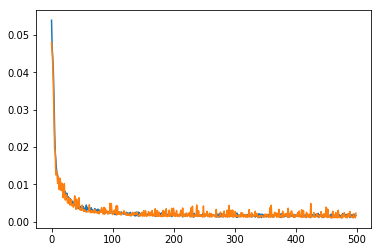

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

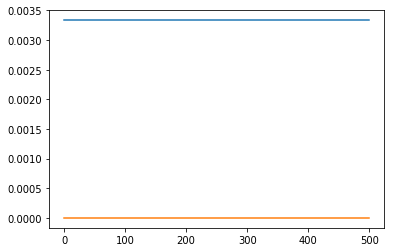

In [24]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

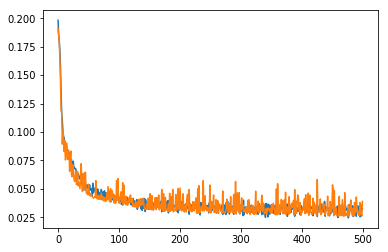

In [25]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])

In [26]:
i = 1
y_train[i]

0.45999421394531187

In [27]:
encoder_model.predict(x_train[:10])[i]

array([0.49524474], dtype=float32)

In [28]:
i = y_train.argmin()
y_train[i:i+2]

array([0.        , 0.73939037])

In [29]:
encoder_model.predict([x_train[i:i+2]])

array([[0.0873381 ],
       [0.74160343]], dtype=float32)

## Decoder
mapping: f -> sin(f)

In [39]:
from keras.utils.generic_utils import get_custom_objects

In [40]:
# saw = Lambda(lambda x: x % 1) # No gradient defined for operation 'mod' (op type: FloorMod)
def saw(x):
     # No gradient defined for operation 'mod' (op type: FloorMod)
    # return x % 1
    
#     return K.tf.where(x < 1, x, K.zeros_like(x))
    return K.tf.where(x < 1, x, x - 1)

def sawDescending(x):
     # No gradient defined for operation 'mod' (op type: FloorMod)
    # return x % 1
#     return K.tf.where(x > 0, x, K.ones_like(x))
    return K.tf.where(x > 0, x, x + 1)

get_custom_objects().update({'saw': Activation(saw), 'sawDescending': Activation(sawDescending)})

# make sure to import this function when loading this model in another module

In [41]:
# # saw = Lambda(lambda x: x % 1) # No gradient defined for operation 'mod' (op type: FloorMod)
# def saw(x):
#      # No gradient defined for operation 'mod' (op type: FloorMod)
#     # return x % 1
#     return K.tf.where(x < 1, x, x - 1)

# def sawDescending(x):
#      # No gradient defined for operation 'mod' (op type: FloorMod)
#     # return x % 1
#     return K.tf.where(x < 0, K.ones_like(x), x)

# get_custom_objects().update({'saw': Activation(saw), 'sawDescending': Activation(sawDescending)})

# # make sure to import this function when loading this model in another module

In [152]:
timesteps, notes

(40, 1)

In [354]:
decoder_input = Input(shape=(notes,))
x = decoder_input

unroll = False

ratio = 0.1
sub_t = int(timesteps * ratio)
super_t = int(timesteps/ sub_t)

# a = ELU(alpha=0.5)
# ThresholdedReLU
# PReLU
# ELU
# LeakyRelu

# x1 = starting value
# x2 :: [decay1, decay2, decay3]
# end of sequence = decay3 * (decay2 * (decay1 * x1))
# full sequence = [decay1 * x1, decay2(decay1 * x1), etc... ]

# x1 might have abias of zero
# TODO x1 ** 0.5
# x2 might disregard its input
# TODO check if x2 can have an offset bias

# decay is non-linear?
# decay = 1/f

width = 2
dims = notes * channels * width
dim1, dim2 = timesteps, 16

x1, x2 = x, x
x1 = Dense(dim2, activation='relu')(x1) # phase (linear)
x2 = Dense(dim2, activation='relu')(x2) # e.g decay: 0.5 * decay, 0.5 * decay * decay
x2 = Dense(dim2, activation='relu')(x2)

# x2_to_x1 = Dense(dim2)(x2)
x2_to_x1 = x2
# x2_to_x1 = Dense(1)(x2_to_x1)
x2_to_x1 = Reshape([dim2, 1])(x2_to_x1)
x2_to_x1 = LocallyConnected1D(1, kernel_size=1, strides=1, activation='relu')(x2_to_x1)
x2_to_x1 = Reshape([16])(x2_to_x1)

x1 = Add()([x1, x2_to_x1])
x1 = RepeatVector(1)(x1)

x2 = RepeatVector(timesteps - 1)(x2)
x = Concatenate(axis=1)([x1, x2])
x = SimpleRNN(dims, return_sequences=True, unroll=unroll)(x)

x = LocallyConnected1D(3, kernel_size=1, strides=1, activation='relu')(x)
x = LocallyConnected1D(1, kernel_size=1, strides=1, activation='relu')(x)

# x = Flatten()(x)
# x = Dense(np.prod(input_shape), activation='relu')(x)
# x = Dense(np.prod(input_shape), activation='sigmoid')(x)
x = Reshape((np.prod(input_shape),))(x)
x = Activation('sigmoid')(x)
x = Reshape(input_shape)(x)

decoder_output = x

decoder_model = Model(decoder_input, decoder_output, name='decoder-')
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_149 (Dense)               (None, 16)           32          input_50[0][0]                   
__________________________________________________________________________________________________
dense_150 (Dense)               (None, 16)           272         dense_149[0][0]                  
__________________________________________________________________________________________________
reshape_92 (Reshape)            (None, 16, 1)        0           dense_150[0][0]                  
__________________________________________________________________________________________________
locally_co

In [355]:
ae = Model(decoder_input, encoder_model(decoder_model(decoder_input)))
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
decoder- (Model)             (None, 40, 1, 1)          926       
_________________________________________________________________
encoder- (Model)             (None, 1)                 49        
Total params: 975
Trainable params: 926
Non-trainable params: 49
_________________________________________________________________


In [356]:
encoder_model.trainable = False

In [357]:
loss = 'mse' # mse mae binary_crossentropy rmsprop adadelta hinge
ae.compile(loss=loss, optimizer='rmsprop', metrics=['accuracy','mae','mse'])

In [358]:
batch_size = 100
epochs = 60

In [359]:
j = 5
history = ae.fit(y_train[:j], y_train[:j], 
    epochs=epochs, batch_size=batch_size, 
    validation_data=(y_test, y_test))

In [360]:
decoder_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy','mae','mse'])

In [372]:
# j = -1
# history = decoder_model.fit(y_train[:j], x_train[:j], 
#     epochs=epochs, batch_size=batch_size, 
#     validation_data=(y_test, x_test))

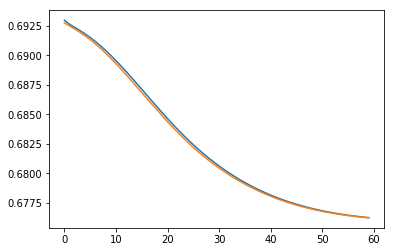

In [363]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

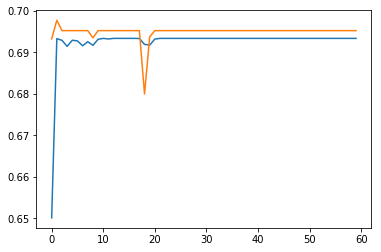

In [364]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

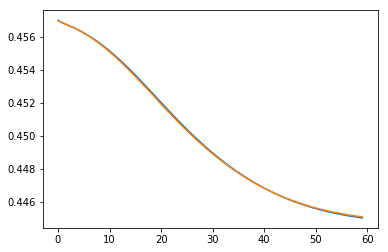

In [365]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])

In [366]:
y_train[:10]

array([0.60969224, 0.45999421, 0.75647234, 0.4772443 , 0.147375  ,
       0.216071  , 0.62131938, 0.33297022, 0.32635377, 0.64138552])

In [367]:
f = [0.1, 0.429, 0.856, 1.4]
y = ae.predict(f)
y

array([[0.9341733],
       [0.9341733],
       [0.9341733],
       [0.9341733]], dtype=float32)

In [368]:
y_train[y_train.argmax()]

0.7999618268937279

In [369]:
y_train[y_train.argmin()]

0.0

m (40, 1)


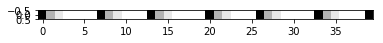

m (40, 1)


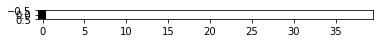

array([0.60969224, 0.45999421, 0.75647234, 0.4772443 , 0.147375  ])

In [370]:
f = y_train[:10]
y = decoder_model.predict(f)
plot.single(x_train[0,:50,0])
plot.single(y[0,:50,0])
# plot.single(x_train[1,:50,0])
f[:5]

m (40, 1)


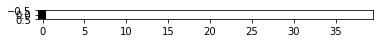

m (40, 1)


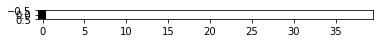

m (40, 1)


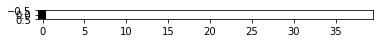

m (40, 1)


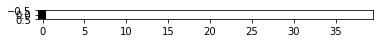

In [371]:
f = [0, 0.3, 0.6, 1.2]
y = decoder_model.predict(f)
plot.single(y[0,:50,0])
plot.single(y[1,:50,0])
plot.single(y[2,:50,0])
plot.single(y[3,:50,0])

m (40, 1)


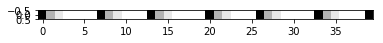

m (40, 1)


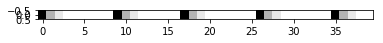

m (40, 1)


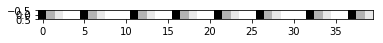

m (40, 1)


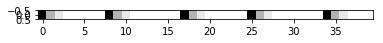

In [352]:
# goal examples
plot.single(x_train[0,:50,0])
plot.single(x_train[1,:50,0])
plot.single(x_train[2,:50,0])
plot.single(x_train[3,:50,0])

In [353]:
y_train[:5]

array([0.60969224, 0.45999421, 0.75647234, 0.4772443 , 0.147375  ])